# Ultimate Data Science Challenge 1

## Part 1: Exploratory Data Analysis
### Key Features:
* Aggregate login counts based on 15 minute time intervals.
* Visualize and describe the resulting time series of login counts to illustrate underlying patterns of the demand.

In [193]:
# import all necessary packages
import json
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

### Data Wrangling and Cleaning:

In [131]:
# load the data into a variable
with open(r"C:\Users\Edwin\Desktop\Springboard Challenge 1\logins.json") as file:
    data = json.load(file)

In [132]:
# get an idea for what the size of the dataset is
print(len(data['login_time']))

93142


In [133]:
i = 0
sample = []
for line in data['login_time']:
    sample.append(line)
    i += 1
    if i == 10:
        break
        
print(sample)

['1970-01-01 20:13:18', '1970-01-01 20:16:10', '1970-01-01 20:16:37', '1970-01-01 20:16:36', '1970-01-01 20:26:21', '1970-01-01 20:21:41', '1970-01-01 20:12:16', '1970-01-01 20:35:47', '1970-01-01 20:35:38', '1970-01-01 20:47:52']


In [134]:
# load all login times into one list
login_datetimes = []
for line in data['login_time']:
    login_datetimes.append(line)

In [135]:
# ensure that all the data has been loaded into the list correctly
print(len(login_datetimes))

93142


In [136]:
# check to see if all entries are going to be the same format by checking string length
entry_len = len(login_datetimes[0])

errors = 0
for entry in login_datetimes:
    if len(entry) != entry_len:
        errors += 1

print("number of errors in login_datetimes: " + str(errors))

number of errors in login_datetimes: 0


In [137]:
# initialize a dataframe with the login time and a count of how many logins occurred at that time for summation
df = pd.DataFrame()

df['login_time'] = login_datetimes
df['login_count'] = 1

In [138]:
# check the new dataframe
df.head()

,login_time,login_count
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [139]:
# check the types of each column
df.dtypes

login_time     object
login_count     int64
dtype: object

In [140]:
# cast the columns to their correct data type
df.login_time = df.login_time.astype('datetime64[ns]')
df.dtypes

login_time     datetime64[ns]
login_count             int64
dtype: object

### Aggregate Login Counts based on 15 Minute Intervals:

In [141]:
# aggregate the dataframe based on 15 minute time intervals
df = df.set_index(pd.DatetimeIndex(df['login_time']))
df.set_index('login_time')
df_15min = df.resample('15Min').sum()

In [142]:
df_15min.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


Text(0.5, 1.0, 'Login Count by 15 Minute Intervals')

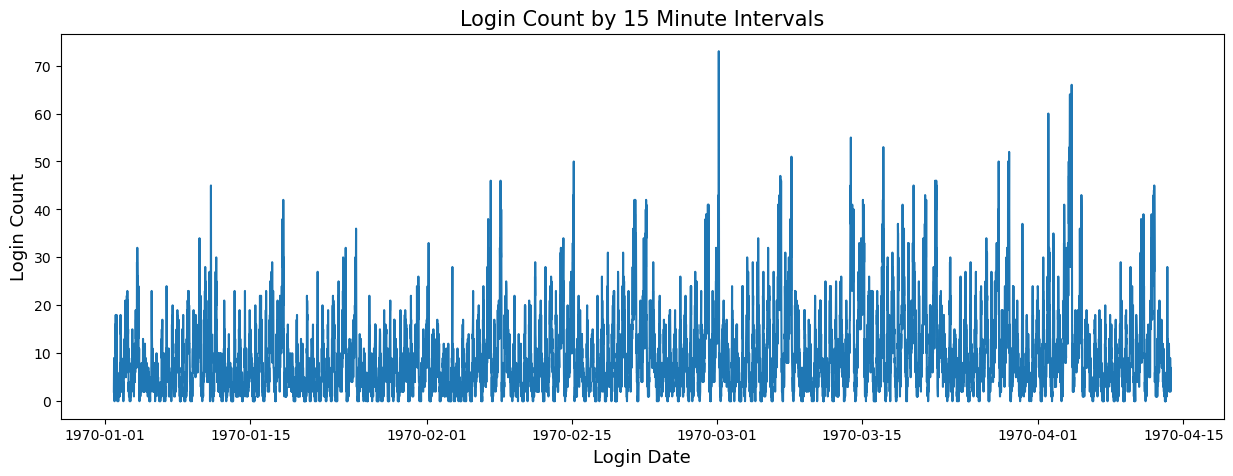

In [143]:
x = df_15min.index
y = df_15min.login_count
fig, axes = plt.subplots(figsize = (15,5))
axes.plot(x,y)
axes.set_xlabel('Login Date', fontsize=13)
axes.set_ylabel('Login Count', fontsize=13)
axes.set_title('Login Count by 15 Minute Intervals', fontsize=15)

As we can see from the graph above, while there seems to be some kind of repeating pattern, the data is too packed for us to clearly see anything really useful. Since there are only a few months listed here, we can surmise that the seemingly repeated pattern is representative of a week cycle. From here, our next steps would be to take a closer look at the weekly cycles and find out what days are the most popular.

### Visualize Daily Login Counts and Peak Traffic Days

In [144]:
df_daily = df.resample('D').sum()
df_daily.head()

,login_count
login_time,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459


In [145]:
df_daily_max = df_daily.resample('W').sum()
df_daily_max.head()

,login_count
login_time,
1970-01-04,2374
1970-01-11,5217
1970-01-18,5023
1970-01-25,4751
1970-02-01,4744


In [146]:
df_fri = df_daily.resample('W-Fri').sum()
df_sat = df_daily.resample('W-Sat').sum()
df_sun = df_daily.resample('W-Sun').sum()

In [147]:
df_fri.head()

,login_count
login_time,
1970-01-02,793
1970-01-09,4730
1970-01-16,5056
1970-01-23,5008
1970-01-30,4847


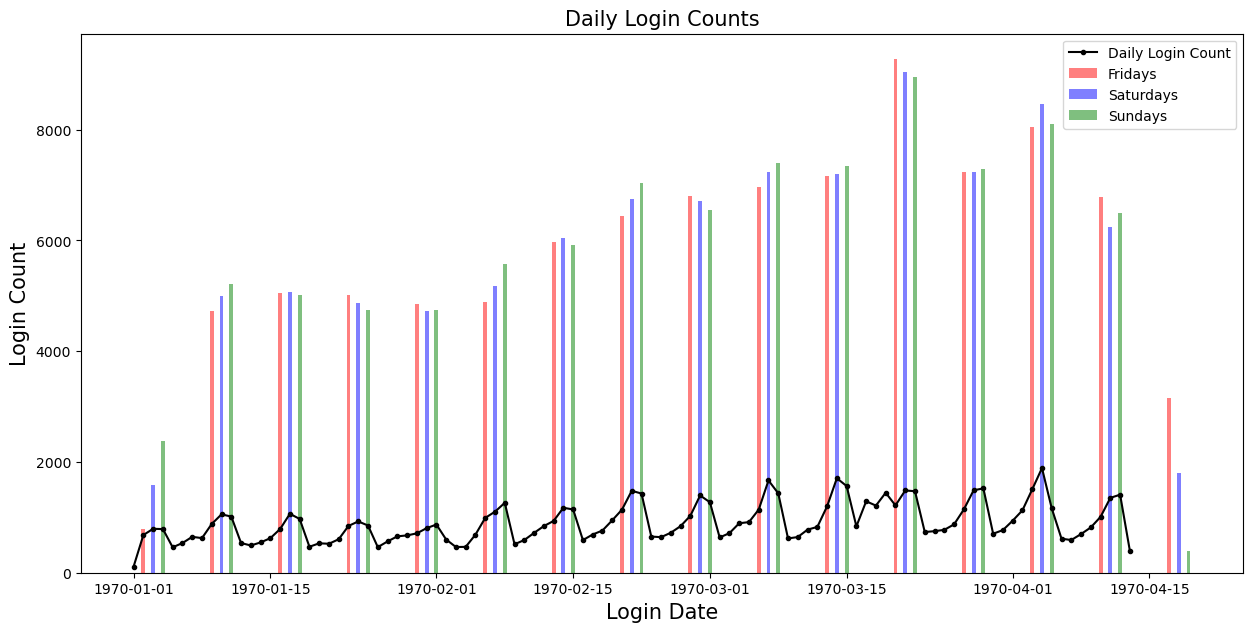

In [148]:
x = df_daily.index
y = df_daily.login_count

x_max = df_daily_max.index
y_max = df_daily_max.login_count

x_fri = df_fri.index
y_fri = df_fri.login_count

x_sat = df_sat.index
y_sat = df_sat.login_count

x_sun = df_sun.index
y_sun = df_sun.login_count


fig, axes = plt.subplots(figsize = (15,7))
plt.xlabel('Login Date', fontsize=15)
plt.ylabel('Login Count', fontsize=15)
plt.title('Daily Login Counts', fontsize=15)

plt.plot(x,y,marker='.', color='k', label='Daily Login Count')

plt.bar(x_fri,y_fri, color='r', alpha = 0.5, width=0.4, label='Fridays')
plt.bar(x_sat,y_sat, color='b', alpha = 0.5, width=0.4, label='Saturdays')
plt.bar(x_sun,y_sun, color='g', alpha = 0.5, width=0.4, label='Sundays')

plt.legend()

The graph above further indicates that there is some form of weekly cycle happening where there are particularly high rates of traffic on Fridays through Sundays, with Saturdays typically experiencing the most traffic out of days of the week. We can take this specificity further and find out if there are specific times of day that are most popular. It is also a good idea to understand the distribution of visits across the week. 

### Visualize The Busiest Hours of the Day:

In [149]:
# lets find out what hours of the day are the busiest
df_hourly = df.resample('H').sum()
df_hourly

,login_count
login_time,
1970-01-01 20:00:00,24
1970-01-01 21:00:00,9
1970-01-01 22:00:00,21
1970-01-01 23:00:00,58
1970-01-02 00:00:00,53
...,...
1970-04-13 14:00:00,32
1970-04-13 15:00:00,19
1970-04-13 16:00:00,22


In [150]:
df_hourly['timestamp'] = df_hourly.index

In [151]:
# create a list of the days of the week of each entry in df_hourly
weekday = [df_hourly['timestamp'][x].weekday() for x in df_hourly['timestamp']]

# map that list to the respective string that matches the day of the week
daysofweek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday = [daysofweek[x] for x in weekday]

In [152]:
df_hourly['Day'] = weekday
df_hourly['Hour'] = [str(df_hourly['timestamp'][x])[-8:] for x in df_hourly['timestamp']]

In [153]:
df_hourly

,login_count,timestamp,Day,Hour
login_time,,,,
1970-01-01 20:00:00,24,1970-01-01 20:00:00,Thursday,20:00:00
1970-01-01 21:00:00,9,1970-01-01 21:00:00,Thursday,21:00:00
1970-01-01 22:00:00,21,1970-01-01 22:00:00,Thursday,22:00:00
1970-01-01 23:00:00,58,1970-01-01 23:00:00,Thursday,23:00:00
1970-01-02 00:00:00,53,1970-01-02 00:00:00,Friday,00:00:00
...,...,...,...,...
1970-04-13 14:00:00,32,1970-04-13 14:00:00,Monday,14:00:00
1970-04-13 15:00:00,19,1970-04-13 15:00:00,Monday,15:00:00
1970-04-13 16:00:00,22,1970-04-13 16:00:00,Monday,16:00:00


In [154]:
# change from a wide format to a long format
daily_hourly_avg = df_hourly.groupby(['Day','Hour']).aggregate({'login_count':'mean'})
unstacked = daily_hourly_avg.unstack()
daily_avg = unstacked.T

In [155]:
index = daily_avg.index
labels = [x[1] for x in index]
labels = pd.Series(labels)
labels = pd.to_datetime(labels, format='%H:%M:%S')

In [156]:
daily_avg.index = labels
daily_avg

Day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
1900-01-01 00:00:00,65.000000,35.400000,83.600000,74.866667,58.285714,43.357143,49.071429
1900-01-01 01:00:00,63.800000,27.600000,104.133333,90.333333,55.500000,40.428571,49.000000
1900-01-01 02:00:00,51.400000,20.800000,107.200000,107.200000,44.642857,28.142857,34.428571
1900-01-01 03:00:00,33.466667,15.733333,104.933333,109.800000,26.785714,14.142857,21.357143
1900-01-01 04:00:00,23.533333,13.733333,114.600000,140.466667,18.214286,10.642857,17.500000
1900-01-01 05:00:00,16.333333,8.066667,72.866667,73.466667,9.714286,8.071429,9.642857
1900-01-01 06:00:00,8.066667,4.400000,27.200000,25.466667,4.785714,3.285714,3.428571
1900-01-01 07:00:00,7.000000,7.400000,11.866667,12.800000,5.785714,4.571429,6.000000
1900-01-01 08:00:00,7.266667,9.800000,8.466667,10.200000,6.785714,6.285714,7.071429
1900-01-01 09:00:00,16.000000,17.066667,7.866667,12.000000,17.928571,17.285714,17.142857


In [157]:
xticks = [str(x)[11:] for x in labels]
print(xticks)

['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00']


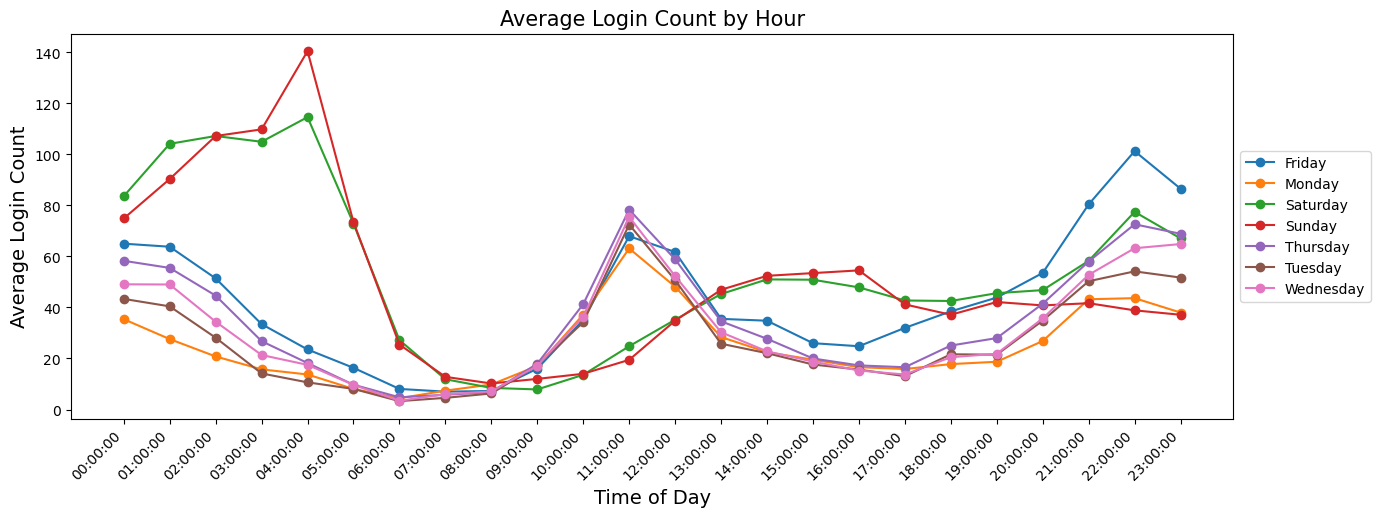

In [158]:
# plot the average login count by hour
fig, axes = plt.subplots(figsize = (15,5))
axes.plot(daily_avg, marker='o')
axes.set_xticks(labels)
axes.set_xticklabels(xticks, rotation=45, ha='right')
axes.set_title('Average Login Count by Hour', fontsize=15)
axes.set_xlabel('Time of Day', fontsize=14)
axes.set_ylabel('Average Login Count', fontsize=14)
axes.legend(daily_avg.columns,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

From the graph above we can see that there are indeed different popular times of day for each of the days of the week. Saturday and Sunday experience the highest traffic at 4AM and have a second resurgence around 2-4PM. As for the weekdays, you can see that they first experience a wave of traffic at 11AM and a second wave at 10PM. While the weekdays all experience relatively the same amount of traffic at 11AM they vary on the second wave of activity at 10PM with Friday experiencing the most at that time. 

Though this gives us a good idea of the times at which the different days experience login traffic, we should delve deeper into their distribution to see if there are significant differences between the days and the amount of logins they receive. 

box plot of each day of the week to show variation in days (maybe even violin plots)
make more commentary throughout each step of the project

In [159]:
# create a dataframe containing the login counts by day
days = ['W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-FRI', 'W-SAT', 'W-SUN']

# initialize an empyty dataframe
daily_lc = {}

for day in days:
    temp = df_daily.resample(day).sum()
    daily_lc[day[2:]] = temp['login_count'].values


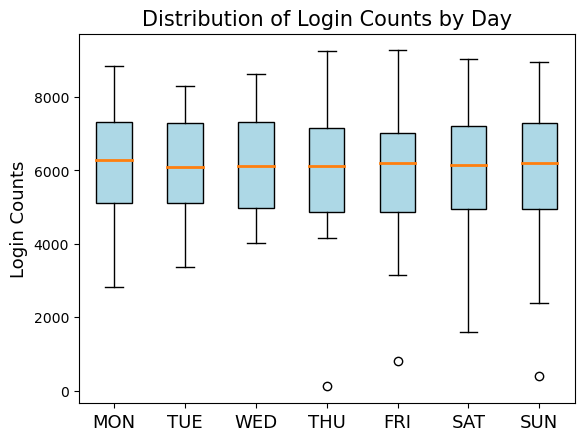

In [160]:
days, login_count = daily_lc.keys(), daily_lc.values()

plt.boxplot(login_count, patch_artist = True,
           boxprops = dict(facecolor = "lightblue"), medianprops = {'linewidth':2.0})
plt.xticks(range(1, len(days) + 1), days, fontsize=13)
plt.ylabel('Login Counts', fontsize=13)
plt.title('Distribution of Login Counts by Day', fontsize=15)
plt.show()

Contrary to what was indicated in previous graphs, our distribution graph shows that there is not a significant difference between the number of login counts experienced by different days. While Saturday and Sunday still experience the largest range of login counts, they do not experience significantly different traffic. This leaves us to look at the differences in time throughout the day.

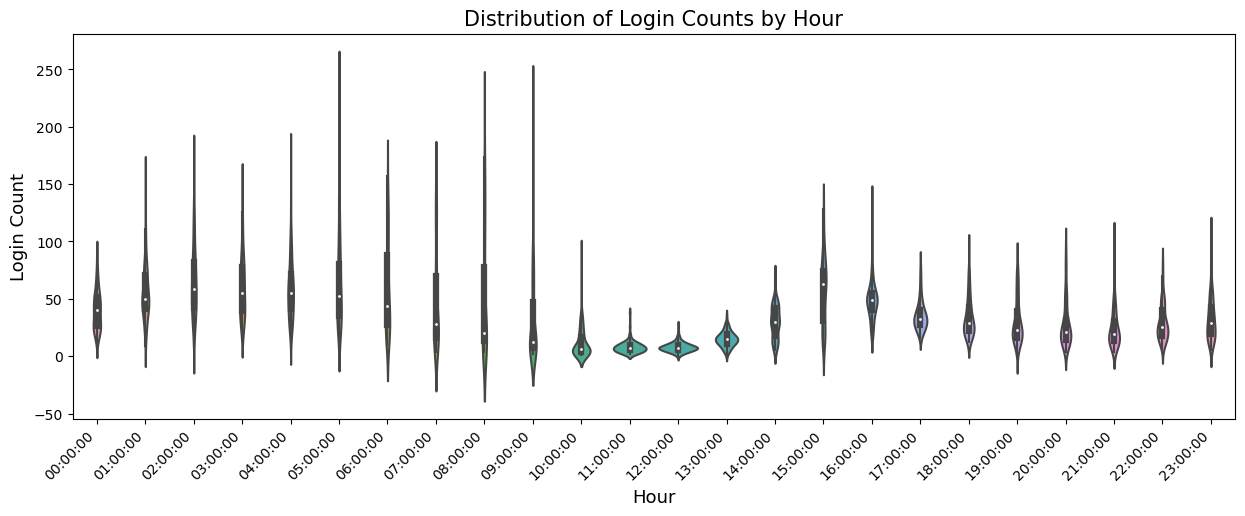

In [161]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.violinplot(data=df_hourly, x='Hour', y='login_count', showfliers=False)
_ = ax.set_xticklabels(xticks, rotation=45, ha='right')
_ = ax.set_title('Distribution of Login Counts by Hour', fontsize=15)
_ = ax.set_ylabel('Login Count', fontsize=13)
_ = ax.set_xlabel('Hour', fontsize=13)

Though we plotted the distribution of login counts by time, this graph is not very helpful (especially during the morning hours) because the ranges of each hour are so large. However, from this graph we can infer that the hours with typically the lowest amount of traffic 11AM, 12PM, and 1PM. It would help us if we could see the hourly distribution by day so we can infer the busiest and slowest times of day for each.

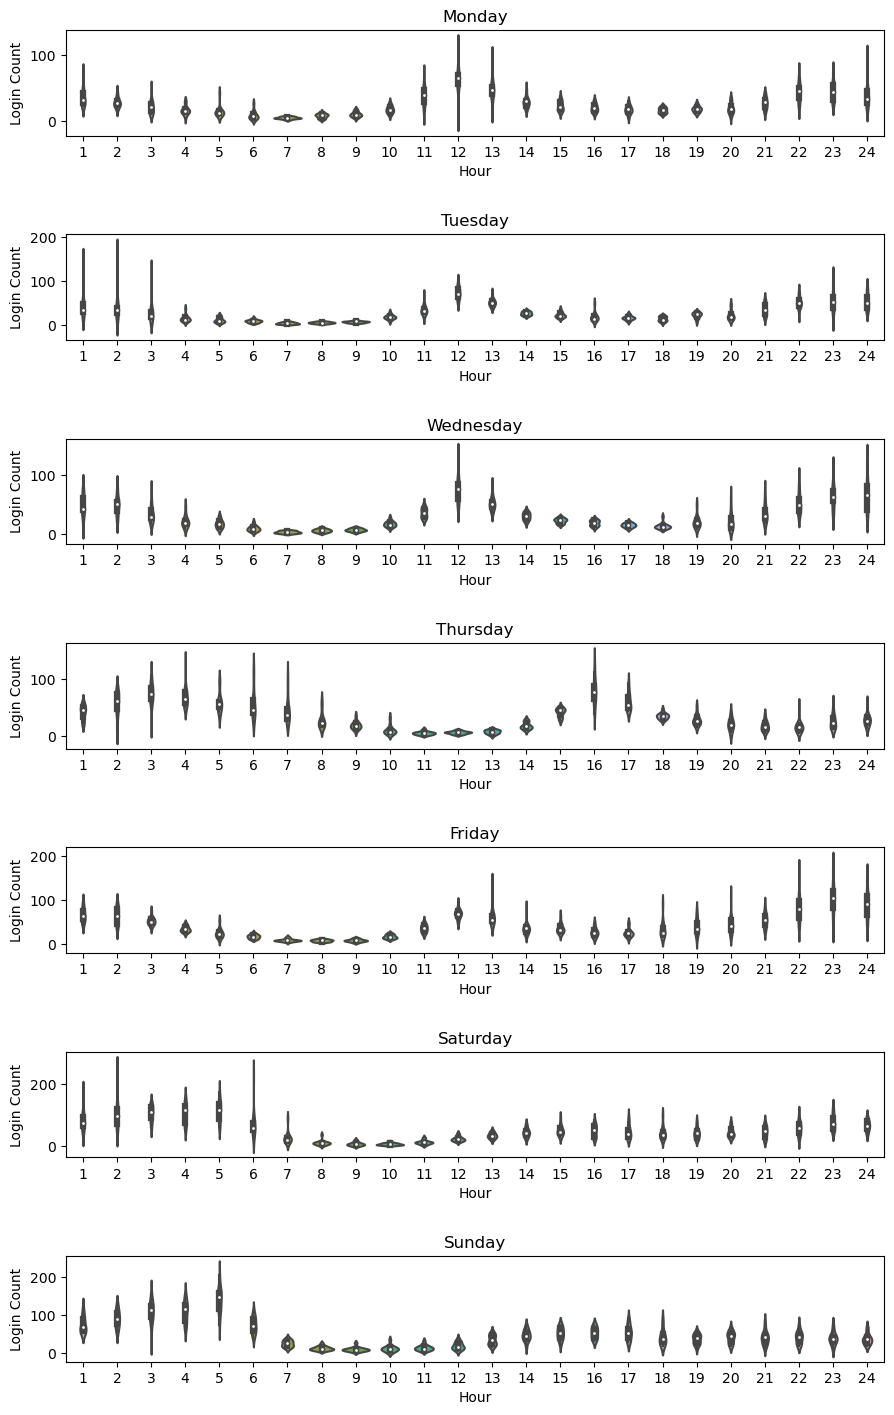

In [162]:
fig, axs = plt.subplots(7,1, figsize=(10, 15))
fig.tight_layout(pad=5.0)
for day, ax in zip(daysofweek, axs.ravel()):
    data = df_hourly[df_hourly['Day']==day]
    sns.violinplot(data=data, x='Hour', y='login_count', ax=ax)
    ax.set_xticklabels(list(range(1,25)), fontsize=10),
    ax.set_title(day, fontsize=12),
    ax.set_ylabel('Login Count', fontsize=10),
    ax.set_xlabel('Hour', fontsize=10)
    
plt.show()

With this set of graphs, we can finally understand the traffic patterns of each day.

Traffic patterns:
1. Monday:
- High traffic hours: 12PM
- Low traffic hours: 7AM-9AM, 6PM/7PM
2. Tuesday:
- High traffic hours: 12PM
- Low traffic hours: 6AM-9AM, 4PM-8PM
3. Wednesday:
- High traffic hours: 12PM, 11PM-12AM
- Low traffic hours: 7AM-9AM, 4PM-8PM
4. Thursday:
- High traffic hours: 3AM, 4PM
- Low traffic hours: 11AM-1PM
5. Friday:
- High traffic hours: 10PM-12AM
- Low traffic hours: 6AM-10AM, 4PM-5PM
6. Saturday:
- High traffic hours: 2AM-5AM
- Low traffic hours: 7AM-12AM
7. Sunday:
- High traffic hours: 3AM-5AM
- Low traffic hours: 7AM-12AM

From this we can see that though Saturday and Sundays experience statistically insignificantly different amounts of traffic compared to the weekdays, they experience that overall same volume in traffic but in a much shorter time frame. Saturdays and Sundays experience the bulk of their daily traffic in 2-3 hours whereas the weekdays generally see their activity spread out over a larger number of hours throughout the day.

# Part 2: Experiment and Metric Design

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?


I would choose the amount of tolls reimbursed as a metric of success for this experiment. This would work as an indicator of travel between the city because an increase in total reimbursements would directly reflect increased traffic across the bridge. Further more, we would also be able to understand if there is an imbalance between the two cities in terms of who is contributing to the increased traffic by looking at the time at which the tolls occur. This is of course assuming that there is datetime data collected alongside the tolls. If there is an increase in tolls but mainly during the day, we can infer that there are more people from Metropolis that are taking advantage of the reimbursements compared to Gotham and vice versa. 

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success

- How will you implement the experiment?

Assuming that data was not collected before, I would establish two periods of data collection - one month each. One month before the reimbursement policy and one month after the reimbursement policy was introduced. This is with the assumption that experiment resources would allow for such a long period of data collection to occur - otherwise shorter periods would also suffice. 

The data to be collected would be the amount of tolls collected and reimbursed as well as the time and date of each toll as it is collected. After the time alloted, the data would be analyzed for percent change in activity. The activity periods would be split up according to hours of daylight - meaning for example that if the sun rose and set at 5AM and 5PM respectively, the toll charges would be categorized accordingly. Tolls collected between the hours of 5AM and 5PM would be categorized as "day time" transactions and those collected between 6PM and 6AM would be categorized as "night time" charges. This would allow us to effectively analyze if there are overall changes in activity of the Metropolis and Gotham residents. 

* what statistical test(s) you will conduct to verify the significance of the observation?


Given that we are looking for an indication an increase or decrease in activity, I would use a one-tailed T test to verify the significance of the observation. Specifically, a one-tailed T test in this case would be helpful since one tailed tests will help us determine statistically significant differences in the desired direction - an increase.

* how you would interpret the results and provide recommendations to the city operations team along with any caveats?

There are multiple ways to interpret the potential results of this experiment with the T test. Given an assumed significance (P-value) of 0.05, here are the different scenarios:

1) Both the "day time" and "night time" amounts of reimbursed tolls do not have a p-value lower than 0.05:

This tells us that there is neither a statistically significant increase in activity relative to before the policy was enacted. Therefore, we would recommend to the city operations team that another strategy be employed to encourage increased activity.
    
2) Both the "day time" and "night time" reimbursed toll totals exhibit a p-value lower than 0.05:

This indicates that both the day and night time periods experienced a significant increase in activity relative to before the policy was enacted. This should support our hypothesis that reimbursing the tolls does support a two-sided increase in activity and therefore does encourage drivers to serve in both cities, thus meriting further and prolonged experimentation.
    
3) Only one of the two time periods exhibit a p-value of lower than 0.05:

This indicates that the policy is only effective at driving an increase in only one of the parties involved and is ineffective for the other party. This would render our policy inconclusive of whether it can encourage BOTH the day and night time dwellers to better serve in both cities. In this case we would recommend an extension of the experiment or an alternate policy be enacted.

# Part 3: Predictive Modelling

### Data Cleaning:

In [163]:
# load the data into a variable
with open(r"C:\Users\Edwin\Desktop\Springboard Challenge 1\ultimate_data_challenge.json") as file:
    data = json.load(file)
    
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [164]:
# check the column types of the dataframe and cast the columns to the correct type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [165]:
# convert object date columns to datetime format
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [167]:
# look for null values in the dataset
df[df.isna().any(axis=1)]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
6,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,Android,0.0,False,100.0,3.95,4.0
9,Winterfell,1,2014-01-03,NaN,1.0,2014-01-05,Android,0.0,False,0.0,2.37,5.0
12,Winterfell,1,2014-01-15,NaN,1.0,2014-03-12,iPhone,0.0,False,100.0,20.29,5.0
14,Astapor,1,2014-01-27,NaN,1.0,2014-01-28,Android,0.0,False,100.0,26.01,5.0
15,Winterfell,1,2014-01-15,NaN,1.0,2014-01-16,Android,0.0,True,100.0,13.20,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49984,Winterfell,1,2014-01-26,NaN,1.0,2014-01-26,Android,0.0,False,0.0,3.50,5.0
49985,Astapor,1,2014-01-26,NaN,1.0,2014-02-25,Android,0.0,False,100.0,1.38,5.0
49989,Winterfell,1,2014-01-24,NaN,1.0,2014-01-31,iPhone,0.0,False,100.0,0.00,5.0
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0


In [168]:
# drop null rows from the dataset
df.dropna(inplace=True)

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    41445 non-null  object        
 1   trips_in_first_30_days  41445 non-null  int64         
 2   signup_date             41445 non-null  datetime64[ns]
 3   avg_rating_of_driver    41445 non-null  float64       
 4   avg_surge               41445 non-null  float64       
 5   last_trip_date          41445 non-null  datetime64[ns]
 6   phone                   41445 non-null  object        
 7   surge_pct               41445 non-null  float64       
 8   ultimate_black_user     41445 non-null  bool          
 9   weekday_pct             41445 non-null  float64       
 10  avg_dist                41445 non-null  float64       
 11  avg_rating_by_driver    41445 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [170]:
# identify the last trip date to serve as our end date
end_date = df['last_trip_date'].max()
end_date

Timestamp('2014-07-01 00:00:00')

In [171]:
# identify the date 30 days ago to serve as our period start date
start_date = end_date - dt.timedelta(30)
start_date

Timestamp('2014-06-01 00:00:00')

In [172]:
# create a list of booleans that indicate if a user is active or inactive
bool_list = []

for date in df['last_trip_date']:
    if (date > start_date and date < end_date):
        bool_list.append('active')
    else:
        bool_list.append('inactive')
        
df['activity_status'] = bool_list
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,activity_status
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,active
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,inactive
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,inactive
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,active
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,Astapor,3,2014-01-03,4.8,1.11,2014-07-01,iPhone,11.1,True,55.6,2.53,4.7,inactive
49994,Astapor,1,2014-01-03,4.6,1.44,2014-05-31,iPhone,37.5,False,25.0,2.25,4.5,inactive
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,active
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,inactive


In [173]:
# group the data into two groups to analyze the differences between the two
active = df[df['activity_status']=='active']
inactive = df[df['activity_status']=='inactive']

In [174]:
active.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,16079.000000,16079.000000,16079.000000,16079.000000,16079.000000,16079.000000,16079.000000
mean,3.558803,4.592070,1.072562,9.081504,62.131594,4.940117,4.759170
std,5.078266,0.539912,0.143675,14.110844,27.463895,4.174281,0.295766
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,46.200000,2.570000,4.600000
50%,2.000000,4.800000,1.010000,2.400000,64.300000,3.690000,4.800000
75%,5.000000,5.000000,1.100000,14.300000,83.300000,5.680000,5.000000
max,125.000000,5.000000,4.500000,100.000000,100.000000,79.340000,5.000000


In [175]:
inactive.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,25366.000000,25366.000000,25366.000000,25366.000000,25366.000000,25366.000000,25366.000000
mean,2.008042,4.607837,1.074620,8.782839,60.699176,5.789619,4.787397
std,3.105506,0.659798,0.226834,20.548752,38.747909,5.650594,0.460133
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.400000,1.000000,0.000000,33.300000,2.320000,4.800000
50%,1.000000,5.000000,1.000000,0.000000,66.700000,3.870000,5.000000
75%,2.000000,5.000000,1.000000,1.400000,100.000000,7.170000,5.000000
max,73.000000,5.000000,8.000000,100.000000,100.000000,79.690000,5.000000


In [176]:
# visualize the differences between the two groups
cols_numeric = list(inactive.describe().columns)
cols_numeric.append('activity_status')
cols_numeric
df_numeric = df[cols_numeric]
cols_numeric.remove('activity_status')

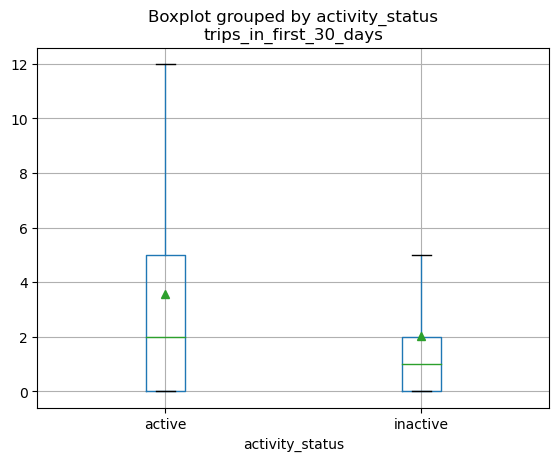

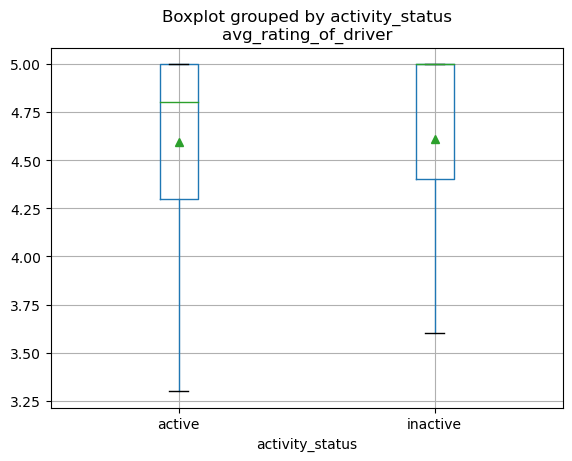

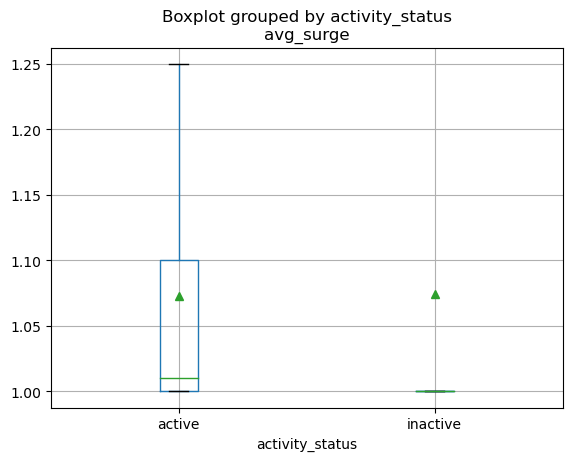

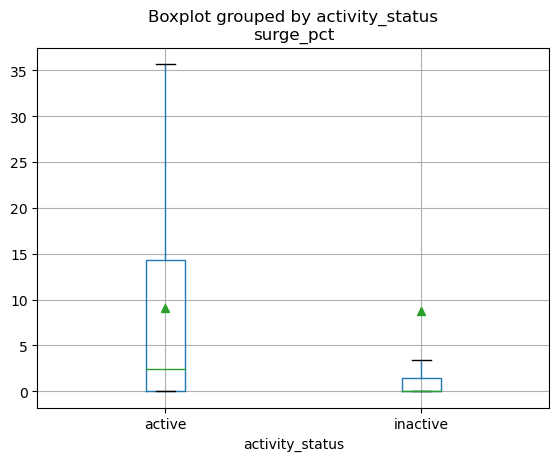

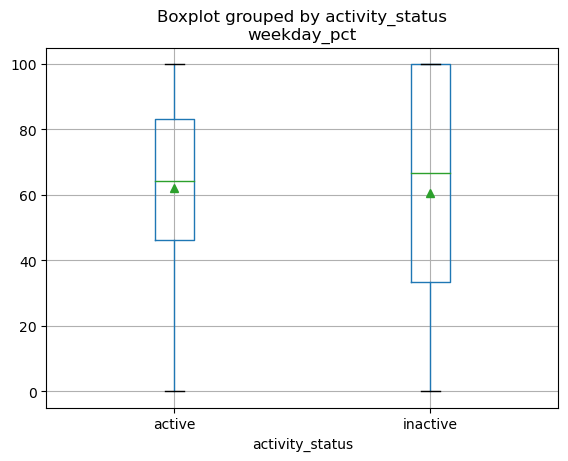

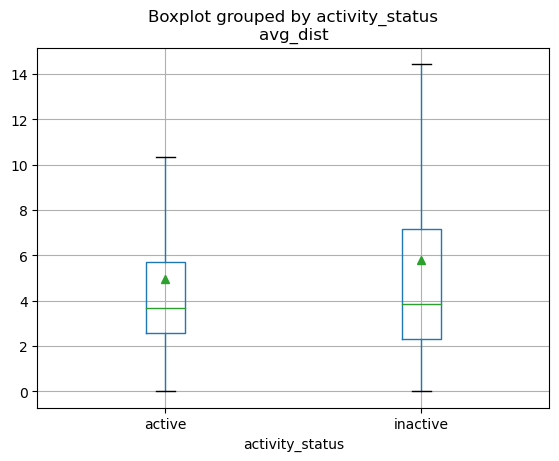

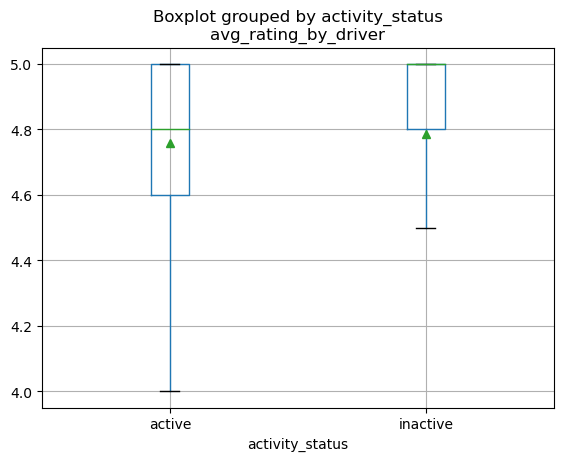

In [177]:
for col in cols_numeric:
    df_numeric.boxplot(column = col, by='activity_status',showfliers=False, showmeans=True)

### Modelling:

In [178]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,activity_status
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,active
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,inactive
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,inactive
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,active
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,inactive


In [180]:
# drop unnecessary variables - datetime columns
df_classifier = df.drop(columns=['signup_date','last_trip_date'])
df_classifier.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,activity_status
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,active
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,inactive
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,inactive
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,active
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,inactive


In [183]:
# encode categorical variables
df_dummy = pd.get_dummies(df_classifier,columns=['city','phone','ultimate_black_user'])
le = preprocessing.LabelEncoder()
df_dummy['activity_status'] = le.fit_transform(df_dummy['activity_status'])
df_dummy.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,activity_status,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,0,0,1,0,0,1,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,1,1,0,0,1,0,1,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,1,1,0,0,0,1,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,0,0,1,0,0,1,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,1,0,0,1,1,0,1,0


In [184]:
# define X and y from the original dataframe
features = list(df_dummy.columns)
features.remove('activity_status')
X = df_dummy[features]
y = df_dummy['activity_status']

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=142)

In [185]:
# create parameter grid for gridsearchCV
params = {
    'max_depth': range (3, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'gamma': [0, 0.5, 1, 2],
    'scale_pos_weight': [0.9, 0.95, 1.0],
    'min_child_weight': [0, 1, 2]
}

In [186]:
# instantiate the model
XGB = XGBClassifier(objective = 'binary:logistic', random_state = 42, colsample_bytree = 0.8)

# instantiate the gridsearchCV with the param grid and fit it to the data
grid_search = GridSearchCV(param_grid= params, estimator = XGB, cv=3, scoring='accuracy')
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                        

In [187]:
# Look at what parameters create the best performance
print(grid_search.best_estimator_)

# Look at the score of the best parameters
print(grid_search.best_score_)

# Instantiate the model with it's best parameters
best_xgb = grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=180, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.7803715767885149


In [188]:
# fit the optimized model on the training data sets
best_xgb.fit(X_train, y_train)

# utilize the model to predict based on the test set
y_pred = best_xgb.predict(X_test)

In [192]:
test_score = accuracy_score(y_test, y_pred)
# print accuracy
print(test_score)

0.7812763903969115


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

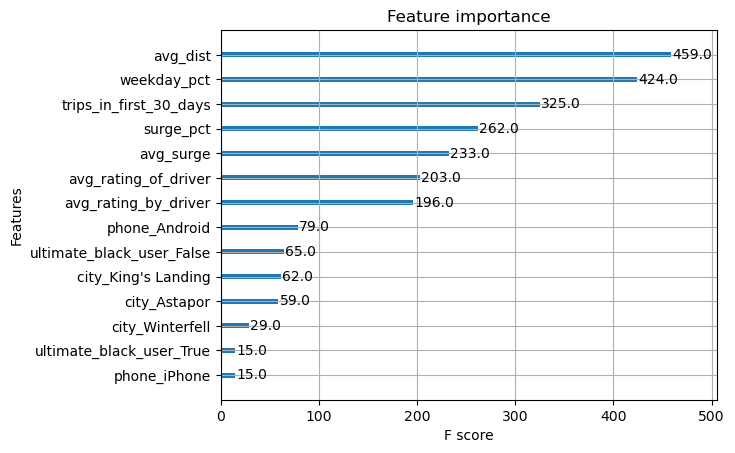

In [194]:
plot_importance(best_xgb)